In [2]:
from __future__ import print_function
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import contrib 
import pandas as pd
from tensorflow.python.framework import ops
import urllib
import keras
import random
from math import exp
from math import log
import scipy
import IPython
import sys
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, BatchNormalization
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
sess = tf.Session(config=config) 
K.set_session(sess)

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Import and format data helper function
with tf.device('/gpu:0'):
    def format_data(filename):
        training = open(filename)
        header = training.readline()
        fields = header.strip().replace('"','').split(',')
        featureNames = fields[:-1]
        labelName = fields[-1]
        X = []
        Y = []
        prev_one = [float(x) for x in training.readline().split(',')]
        y_line = [float(x) for x in training.readline().split(',')]
        for l in training:
            X.append(prev_one)
            Y.append(y_line[-1])
            prev_one = y_line
            y_line = [float(x) for x in l.split(',')]
            
        X = np.array(X)
        Y = np.array(Y)
        Y = Y.astype(int)
        nb_classes = 15
        Y = np.eye(nb_classes)[Y]
        X = X
        Y = np.roll(Y,2)
        
        print(Y[5,])
        print(X[5,:])

        return X, Y

In [4]:
# Import and Format Training Set
X_train, Y_train = format_data('training.csv')
X_train = X_train.reshape(((X_train.shape[0], 1, 13)))

# Import and Format Dev Set
X_dev, Y_dev = format_data('dev.csv')
X_dev = X_dev.reshape(((X_dev.shape[0], 1, 13)))


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.0000e+00  1.0000e+00  5.0000e+00  8.2000e+01  1.7000e+01  5.0000e+02
  1.8460e+03  2.7719e+02  4.0000e+00  3.5000e+02  7.4000e+01  1.0270e+03
 -1.0000e+00]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.20000000e+01  4.00000000e+00  7.00000000e+00  9.43000000e+02
  3.20000000e+01  1.62200000e+03  4.14000000e+02  2.77985548e+02
  1.00000000e+00  1.48000000e+02  8.70000000e+01  1.01600000e+03
 -1.00000000e+00]


In [5]:
# Calculate evaluation metrics of the model
def model_eval(yhat, Y):
    predict_op = np.argmax(yhat, 1)
    truth_label = np.argmax(Y, 1)
    print(np.sum(predict_op))
    print(np.sum(truth_label))
    counter_tp = 0
    counter_fn = 0
    counter_fp = 0
    counter_tn = 0
    total_prediction = truth_label.shape[0]
    for group in range(truth_label.shape[0]):
        if (truth_label[group] > 3 and predict_op[group] > 3):
            counter_tn += 1
        if (truth_label[group] <= 3 and predict_op[group] <= 3):
            counter_tp += 1
        if (truth_label[group] > 3 and predict_op[group] <= 3):
            counter_fp += 1
        if (truth_label[group] <= 3 and predict_op[group] > 3):
            counter_fn += 1
    binary_accuracy = (counter_tp + counter_tn)/(counter_tp + counter_tn + counter_fp + counter_fn)
    binary_precision = (counter_tp)/(counter_tp + counter_fp)
    binary_recall = (counter_tp)/(counter_tp + counter_fn)
    f_1 = (2*binary_precision*binary_recall)/(binary_precision + binary_recall)
    correct_prediction = np.equal(predict_op, np.argmax(Y, 1))
    accuracy = np.mean(correct_prediction.astype("float"), axis=0)
    
    return accuracy, binary_accuracy, f_1

Train on 88614 samples, validate on 6127 samples
Epoch 1/60
 - 61s - loss: 2.1844 - val_loss: 1.9331
Epoch 2/60
 - 56s - loss: 1.6385 - val_loss: 1.8119
Epoch 3/60
 - 57s - loss: 1.5409 - val_loss: 1.8073
Epoch 4/60
 - 56s - loss: 1.5241 - val_loss: 1.8109
Epoch 5/60
 - 57s - loss: 1.5196 - val_loss: 1.8118
Epoch 6/60
 - 57s - loss: 1.5187 - val_loss: 1.8139
Epoch 7/60
 - 57s - loss: 1.5183 - val_loss: 1.8109
Epoch 8/60
 - 57s - loss: 1.5182 - val_loss: 1.8096
Epoch 9/60
 - 57s - loss: 1.5178 - val_loss: 1.8116
Epoch 10/60
 - 57s - loss: 1.5176 - val_loss: 1.8115
Epoch 11/60
 - 57s - loss: 1.5174 - val_loss: 1.8110
Epoch 12/60
 - 57s - loss: 1.5176 - val_loss: 1.8112
Epoch 13/60
 - 57s - loss: 1.5173 - val_loss: 1.8094
Epoch 14/60
 - 57s - loss: 1.5170 - val_loss: 1.8070
Epoch 15/60
 - 57s - loss: 1.5173 - val_loss: 1.8099
Epoch 16/60
 - 57s - loss: 1.5170 - val_loss: 1.8107
Epoch 17/60
 - 57s - loss: 1.5164 - val_loss: 1.8060
Epoch 18/60
 - 57s - loss: 1.5159 - val_loss: 1.8002
Epoch 

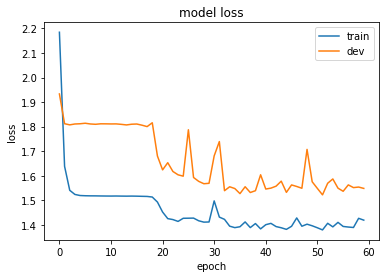

[[1.3844010e-04 2.8773930e-02 4.6631196e-01 ... 6.7661083e-03
  7.3582586e-03 2.5920967e-02]
 [1.5212900e-03 5.8734000e-01 2.0581146e-01 ... 3.9773146e-03
  2.8312393e-03 9.5388982e-03]
 [1.3747021e-03 5.6294239e-01 2.1744423e-01 ... 4.1516605e-03
  3.0385281e-03 1.0191688e-02]
 ...
 [3.6723402e-04 4.5449644e-02 4.8502207e-01 ... 5.8279792e-03
  3.1238806e-03 3.2686617e-02]
 [9.0577356e-05 1.0188511e-02 4.7521898e-01 ... 5.8122789e-03
  7.3615210e-03 2.4619536e-02]
 [7.6024875e-04 1.0334217e-01 4.5697635e-01 ... 8.0198739e-03
  6.5949778e-03 2.4804465e-02]]
9565
13140


In [ ]:
# Implementing LSTM model

model = Sequential()
model.add(LSTM(100, return_sequences=True, activation = None, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(LSTM(60, return_sequences=True, activation = None))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(LSTM(50, activation = None))
model.add(Dense(15))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit network
history = model.fit(X_train, Y_train, epochs=60, batch_size=70, validation_data=(X_dev, Y_dev), verbose=2, shuffle=False)

# Summarize history of loss for plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

# Calculate Dev Accuracy
yhat_dev = model.predict(X_dev)
print(yhat_dev)
dev_accuracy, dev_binary_accuracy, dev_f_1 = model_eval(yhat_dev, Y_dev)


# Calculate Train Accuracy
yhat_train = model.predict(X_train)
print(yhat_train)
train_accuracy, train_binary_accuracy, train_f_1 = model_eval(yhat_train, Y_train)

# Print results
print("Train Accuracy:", train_accuracy)
print("Train Accuracy (binary): ", train_binary_accuracy)
print("Train F-1 (binary): ", train_f_1)

print("Dev Accuracy:", dev_accuracy)
print("Dev Accuracy (binary): ", dev_binary_accuracy)
print("Dev F-1 (binary): ", dev_f_1)



In [ ]:
matrix = metrics.confusion_matrix(np.argmax(Y_dev,axis=1), np.argmax(yhat_dev, axis=1))